In [1]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import torch.nn as nn
import sys
import os
project_root = os.path.abspath("..")  # Adjust if needed
import pytorch_lightning as pl
# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)
from collections import Counter

from src.utils.data_utils import *
from src.dataset_classes.pointDataset import *
from proteinshake.datasets import ProteinFamilyDataset
from proteinshake.tasks import LigandAffinityTask
import random
from src.models.graphVAE import GraphVAE
from src.models.basicVae import LitBasicVae

from torch.utils.data import Dataset, Subset
from torch_geometric.utils import to_dense_batch, to_dense_adj
import numpy as np
from src.utils.data_utils import *
from src.dataset_classes.graphDataset import *
from src.dataset_classes.sequenceDataset import *

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


# Get Protein Family Labels

In [2]:
point_data = ProteinFamilyDataset(root='../data').to_point().torch()
seq_dataset = SequenceDataset(point_data, 500, return_proteins=True)
families = [k[1]['protein']['Pfam'][0] for k in seq_dataset.org_protein_data]

# Count occurrences of each element
counter = Counter(families)

100%|██████████| 31109/31109 [00:07<00:00, 4317.81it/s]


In [127]:
counter.most_common(20)

[('PF00069', 431),
 ('PF00959', 356),
 ('PF07714', 286),
 ('PF00565', 262),
 ('PF00067', 240),
 ('PF00062', 217),
 ('PF00076', 198),
 ('PF01353', 198),
 ('PF00042', 180),
 ('PF00595', 176),
 ('PF00061', 171),
 ('PF00071', 171),
 ('PF13499', 162),
 ('PF00089', 161),
 ('PF00194', 160),
 ('PF00096', 154),
 ('PF13354', 149),
 ('PF00018', 125),
 ('PF00001', 119),
 ('PF00041', 107)]

In [128]:
top_families = [i[0] for i in counter.most_common(20)[:20]]
top_family_indices = np.array([idx for idx, k in enumerate(seq_dataset.org_protein_data) if k[1]['protein']['Pfam'][0] in top_families])
top_family_labels = np.array([k[1]['protein']['Pfam'][0] for idx, k in enumerate(seq_dataset.org_protein_data) if k[1]['protein']['Pfam'][0] in top_families])

In [129]:
basic_results = []
graph_results = []
point_results = []
basic_fold_dir = '../data/Beta_BasicData'
graph_fold_dir = '../data/Beta_GraphData'

basic_data_dir = sorted(os.listdir(basic_fold_dir))
graph_data_dir= sorted(os.listdir(graph_fold_dir))

for basic_data in basic_data_dir:
    basic_result = np.load(basic_fold_dir+'/'+basic_data)

    basic_results.append(basic_result)

for graph_data in graph_data_dir:
    graph_result = np.load(graph_fold_dir+'/'+graph_data)

    graph_results.append(graph_result)

In [148]:
top_prot_dict = dict(zip(list(np.unique(top_family_labels)), list(np.array([i for i in range(20)]))))

latent_vectors = graph_results[0][top_family_indices,:]

sil_score = silhouette_score(latent_vectors, top_family_labels)
db_score = davies_bouldin_score(latent_vectors, top_family_labels)
print(f"Silhouette Score: {sil_score:.3f}, Davies-Bouldin Index: {db_score:.3f}")

Silhouette Score: 0.192, Davies-Bouldin Index: 2.501


In [149]:
U, S, V = torch.pca_lowrank(torch.tensor(latent_vectors), q=None, center=True, niter=2)
projected_data = torch.matmul(torch.tensor(latent_vectors), V[:, :2]).numpy()

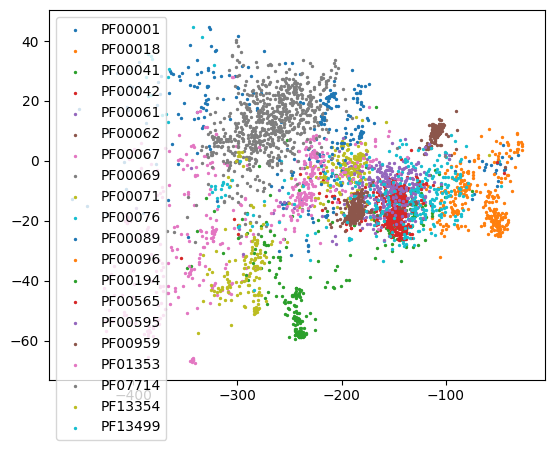

In [150]:
# plt.scatter(projected_data[:,0], projected_data[:,1], s = 2, color = 'b')

for i in list(np.unique(top_family_labels)):
    plt.scatter(projected_data[np.where(top_family_labels == i)[0], 0], projected_data[np.where(top_family_labels == i)[0], 1], s = 2, label = i)
plt.legend()

In [151]:
sil_score = silhouette_score(projected_data, top_family_labels)
db_score = davies_bouldin_score(projected_data, top_family_labels)
print(f"Silhouette Score: {sil_score:.3f}, Davies-Bouldin Index: {db_score:.3f}")

Silhouette Score: 0.052, Davies-Bouldin Index: 6.065


# RandomForest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X = latent_vectors[:1000, :]
y = np.array([top_prot_dict[i] for i in top_family_labels])[:1000]
rf = RandomForestClassifier(random_state=0, class_weight="balanced")


param_grid = {
    'n_estimators': [i for i in range(20,500,20)],
    'max_depth': [i for i in range(5,100,5)],
    'min_samples_split': [i for i in range(5,20,5)],
    'min_samples_leaf': [i for i in range(1,20,2)],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)


rf.fit(X, y)
# print(clf.predict([[0, 0, 0, 0]]))

RandomForestClassifier(class_weight='balanced', max_depth=200, n_estimators=200,
                       random_state=0)

In [168]:
np.sum(clf.predict(latent_vectors[1000:, :]) == np.array([top_prot_dict[i] for i in top_family_labels])[1000:])

2648

In [170]:
from sklearn.metrics import classification_report, confusion_matrix
x_test = latent_vectors[1000:, :]
y_test = np.array([top_prot_dict[i] for i in top_family_labels])[1000:]
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        91
           1       0.79      0.90      0.84        90
           2       0.89      0.51      0.65        78
           3       0.95      0.82      0.88       130
           4       0.77      0.96      0.86       136
           5       1.00      0.90      0.95       166
           6       0.86      0.94      0.90       175
           7       0.76      0.92      0.83       314
           8       0.86      0.89      0.87       127
           9       0.71      0.62      0.66       159
          10       0.90      0.95      0.92       116
          11       0.87      1.00      0.93       111
          12       1.00      0.95      0.97       132
          13       0.99      0.97      0.98       206
          14       0.67      0.84      0.74       133
          15       0.99      0.99      0.99       271
          16       0.96      0.94      0.95       140
          17       0.89    

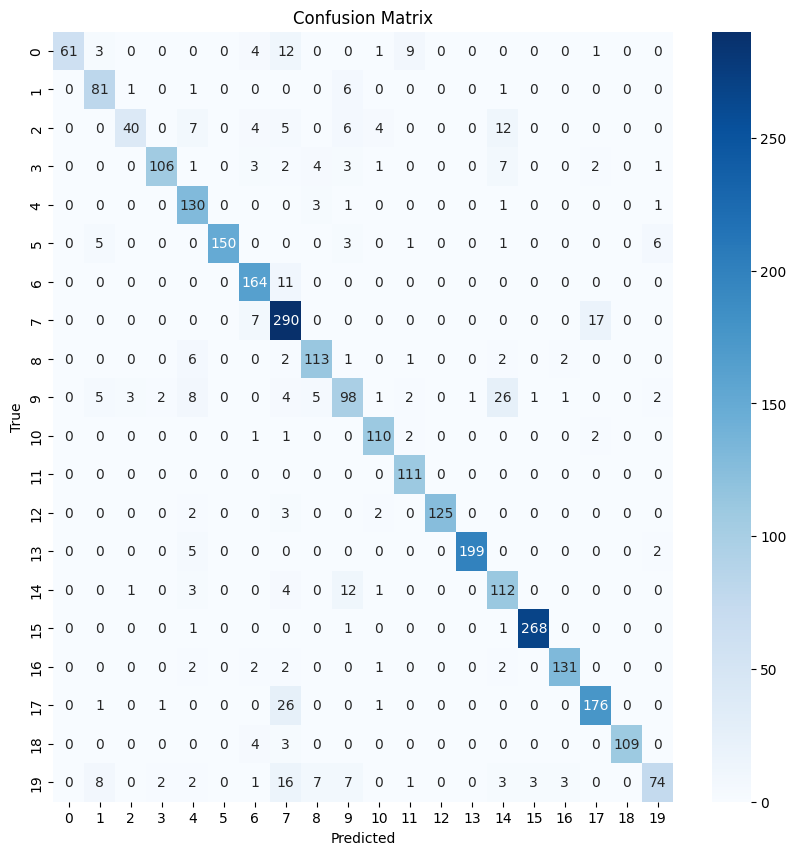

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()
# ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test, cmap="Blues", size = (10,10))
# plt.show()